# Assessment of meso-micro offline coupling methodology based on driving CFDWind single-column-model with WRF tendencies: the GABLS3 diurnal cycle case
*Javier Sanz Rodrigo, National Renewable Energy Laboratory (CENER), Sarriguren, Spain, jsrodrigo@cener.com*

April 2017 

## Introduction
This notebook provides the model evaluation process developed for the assessment of a methodology for testing atmospheric boundary layer models under realistic mesoscale forcing. Tendencies from WRF are used as inputs for CFDWind single-column-model (SCM) to reproduce the GABLS3 diurnal cycle at the Cabauw site. A sensitivity test is conducted to test different SCM settings as well as profile nudging to dynamically correct for model bias. 

This work has been used to set up a benchmark for other wind energy models dealing with meso-micro coupling. The benchmark was launched at the Torque 2016 conference [1] and the results of this study with CFDWind1D have been published in [2]. 

## Benchmark Set-Up
Background information and benchmark set-up can be found in: http://windbench.net/gabls-3

## CFDWind1D Simulations
The following simulations were conducted in the sensitivity analysis to target the following model evaluation objectives:

1. Demonstrate consistency of online (WRF) vs asynchronous meso-micro coupling
2. Evaluate the choice of turbulent closure with realistic forcing
3. Quantify the impact of the choice of surface boundary conditions on fluxes and quantities of interest
4. Quantify the relative importance of mesoscale tendencies on quantities of interest
5. Assess bias-correction nudging method using typical wind energy mast configurations
6. Assess bias-correction nudging method using typical wind energy lidar configurations

| SimID | Turbulence | Surface B.C. | Forcing | Objectives | 
|:----:|:-----:|:----------:|:--------:|:------------:|
| WRF-YSU | YSU | Noah | ERA Interim | 1 |
| ke_T2 (ref) | $k-\epsilon$ | WRF $T_2$ | WRF tendencies | 1 |
| Sl_T2 | $S-l$ | WRF $T_2$ | WRF tendencies | 2 |
| kl_T2 | $k-l$ | WRF $T_2$ | WRF tendencies | 2 |
| ke_T2wt | $k-\epsilon$ | WRF $T_2$ and $w\theta_0$| WRF tendencies | 3 |
| ke_Tsk | $k-\epsilon$ | WRF $\Theta_0$| WRF tendencies | 3 |
| ke_T2obs | $k-\epsilon$ | Observed $T_2$| WRF tendencies | 3 |
| noTadv | $k-\epsilon$ | WRF $T_2$| without $\Theta_{adv}$ tendency | 4 |
| noTadvUadv | $k-\epsilon$ | WRF $T_2$| without advection tendencies | 4 |
| noTadvUadv_Sg0 | $k-\epsilon$ | WRF $T_2$| only surface pressure gradient | 4 |
| UVTnud80 | $k-\epsilon$ | Observed $T_2$| $U,V$: 10-80 m; $\Theta$: 2-80 m; $\tau_{nud}$ = 60 min | 5 |
| UVTnud120 | $k-\epsilon$ | Observed $T_2$| $U,V$: 10-120 m; $\Theta$: 2-120 m; $\tau_{nud}$ = 60 min | 5 |
| UVTnud200 | $k-\epsilon$ | Observed $T_2$| $U,V$: 10-200 m; $\Theta$: 2-200 m; $\tau_{nud}$ = 60 min | 5 |
| UVTnud200_tau10 | $k-\epsilon$ | Observed $T_2$| $U,V$: 10-200 m; $\Theta$: 2-200 m; $\tau_{nud}$ = 10 min | 5 |
| UVnud400 | $k-\epsilon$ | WRF $T_2$| $U,V$: 40-400 m; $\tau_{nud}$ = 60 min | 6 |
| UVnud200 | $k-\epsilon$ | WRF $T_2$| $U,V$: 40-200 m; $\tau_{nud}$ = 60 min | 6 |
| UVnud200_tau30 | $k-\epsilon$ | WRF $T_2$| $U,V$: 40-200 m; $\tau_{nud}$ = 30 min | 6 |
| UVnud200_tau10 | $k-\epsilon$ | WRF $T_2$| $U,V$: 40-200 m; $\tau_{nud}$ = 10 min | 6 |

Remarks:
- All surface boundary conditions use Monin-Obukhov similarity theory (MOST)
- All use the same WRF tendencies, adding nudging or modified tendencies as indicated
- Details about the CFDWind1D model settings and nudging methodology can be found in [2]
- All the simulations are run on a 4-km long log-linear grid with 301 levels and a time step of 1 s
- The $k-\epsilon$ model of Sogachev et a. (2012) [3] is used as a reference, with the following set of constants:  $\kappa$ = 0.4, $C_{\epsilon1}$ = 1.52, $C_{\epsilon2}$ = 1.833, $\sigma_k$ = 2.95, $\sigma_{\epsilon}$ = 2.95 and $C_\mu$ = 0.03 








## Load libraries and define input data

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import spatial
import datetime
import netCDF4 
import pandas as pd
from scipy import interpolate
import scipy.integrate as integrate
import statsmodels.api as sm
import os

# Constants
K       = 0.41            # von Karman constant
g       = 9.81            # [m s-2]
R_air   = 287.058         # Specific gas constant for dry air [J kg-1 K-1]
Cp_air  = 1005            # Specific heat of air [J kg-1 K-1]
P0      = 100000.         # Reference pressure [Pa]

# Site ID
siteID = 'GABLS3'
lat_s = 51.971   # degrees N
lon_s = 4.927    # degrees E

# Evaluation Period and reference Rotor chararcteristics 
datefrom  = datetime.datetime(2006, 7, 1, 12, 0, 0)       # Origin of evaluation period
dateto    = datetime.datetime(2006, 7, 2, 12, 0, 0)       # End of evaluation period 
Hhub = 120.         # hub-height
Drot = 160.         # rotor diameter
ts = 10             # sampling frequency to evaluate [min]

# Mesoscale tendencies averaging settings
tav = 60.0          # Time averaging time used in simulations [min]
Lav = 9000.0        # Spatial averaging [m] 

# Load Simulation data

In [20]:
dirsim = './data'
filesim = [dirsim + '/GABLS3_tendencies_d02_YSU_w60_L9000.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_2.nc',
           
           dirsim + '/GABLS3_CFDWindSCM_turb0_T2_9.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb1_T2_10.nc',

           dirsim + '/GABLS3_CFDWindSCM_turb5_T2wt_6.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_Tsk_7.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2obs_11.nc',

           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_noTadv_3.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_noTadvUadv_4.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_noTadvUadvSg0_5.nc',
           
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2obs_UVTnud2-80_12.nc',           
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2obs_UVTnud2-120_13.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2obs_UVTnud2-200_20.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2obs_UVTnud2-200tau10_21.nc',          

           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_UVnud40-400_14.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_UVnud40-200_15.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_UVnud40-200tau30_16.nc',
           dirsim + '/GABLS3_CFDWindSCM_turb5_T2_UVnud40-200tau10_17.nc',
           ]
           

simID = ['WRF-YSU','ke_T2',
         'Sl_T2','kl_T2',
         'ke_T2wt','ke_Tsk','ke_T2obs',
         'noTadv','noTadvUadv','noTadvUadv_Sg0',
         'UVTnud80','UVTnud120','UVTnud200','UVTnud200_tau10',
         'UVnud400','UVnud200','UVnud200_tau30','UVnud200_tau10'] 

simtype = ['meso','micro',
           'micro','micro',
           'micro','micro','micro',
           'micro','micro','micro',
           'micro','micro','micro','micro',
           'micro','micro','micro','micro']

Nsim = len(filesim)

# Create a list with the simulation datasets 
t = []; U = []; V = []; Th = []; z = []; S = []; WD = []; TKE = []
us = []; wt = []; T2 = []; L = []; Psfc = []

zflux = 3.0     # height to extract surface values from microscale simulation
for isim in range(0,Nsim):
    f = netCDF4.Dataset(filesim[isim], 'r')   
    times = f.variables['time'][:]
    idates = np.where(np.logical_and(times >= mdates.date2num(datefrom), times < mdates.date2num(dateto)))[0] 
    t.append(pd.DataFrame(f.variables['time'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())       
    U.append(pd.DataFrame(f.variables['U'][idates,:], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
    V.append(pd.DataFrame(f.variables['V'][idates,:], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
    Th.append(pd.DataFrame(f.variables['Th'][idates,:], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
    z.append(f.variables['z'][:])
    S.append((U[isim]**2 + V[isim]**2)**0.5)
    WD.append(180 + np.arctan2(U[isim],V[isim])*180/np.pi)
    if simtype[isim] == 'micro':
        zf = f.variables['z'][:]
        izflux = np.where(abs(zf-zflux) == min(abs(zf-zflux)))[0][0]
        iz2 = int(np.where(abs(z[isim]-2.)==min(abs(z[isim]-2.)))[0][0])
        us.append(pd.DataFrame(f.variables['ust'][idates,izflux], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        L.append(pd.DataFrame(f.variables['L'][idates,izflux], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        wt.append(pd.DataFrame(f.variables['wt'][idates,izflux], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        T2.append(pd.DataFrame(f.variables['Th'][idates,iz2], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        Psfc.append([])
        TKE.append(pd.DataFrame(f.variables['TKE'][idates,:], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())        
    else:
        us.append(pd.DataFrame(f.variables['ust'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        L.append(pd.DataFrame(f.variables['L'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        wt.append(pd.DataFrame(f.variables['wt'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        T2.append(pd.DataFrame(f.variables['T2'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())
        Psfc.append(pd.DataFrame(f.variables['Psfc'][idates], index = mdates.num2date(f.variables['time'][idates])).resample(str(ts)+'Min').mean())         
        TKE.append(pd.DataFrame(data=None, columns=U[isim].columns,index=U[isim].index))        
    f.close()


## Load Observations

In [21]:
# Note that the file 'gabls3_scm_cabauw_obs_v33.nc' can be obtained from the KNMI GABLS3 website
# http://projects.knmi.nl/gabls/gabls3_scm_cabauw_obs_v33.nc
# Alternatively, it is also provided in the Windbench/GABLS3 input dataset

dirobs = './data'
fileobs = dirobs + '/gabls3_scm_cabauw_obs_v33.nc'
nodata = -9999.0                          # missing data flag
date0 = datetime.datetime(2006,7,1,0,0,0) # origin of time_obs

f1 = netCDF4.Dataset(fileobs, 'r')
dates_obs = f1.variables['date'][:]
time_obs = f1.variables['time'][:]   # 'hours since 2006-07-01 00:00:00 0:00'   

date_obs = []                   
for i in range (0,len(time_obs)):
    date_obs.append(date0 + datetime.timedelta(seconds = np.int(time_obs[i]*3600.0)))

ifrom_obs=0
for j in range(0,len(date_obs)):
    if date_obs[j] <= datefrom:
        ifrom_obs = j
ito_obs=0
for j in range(0,len(date_obs)):
    if date_obs[j] <= dateto:
        ito_obs = j+1

date_obs = mdates.date2num(date_obs[ifrom_obs:ito_obs])
time_obs = 24.0*(date_obs - date_obs[0])
     
# Surface variables
ustar_obs = pd.DataFrame(np.ma.array(f1.variables['ustar'][ifrom_obs:ito_obs], mask=(f1.variables['ustar'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
U10_obs = pd.DataFrame(np.ma.array(f1.variables['u10m'][ifrom_obs:ito_obs], mask=(f1.variables['u10m'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
V10_obs = pd.DataFrame(np.ma.array(f1.variables['v10m'][ifrom_obs:ito_obs], mask=(f1.variables['v10m'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
S10_obs = pd.DataFrame(np.ma.array(f1.variables['f10m'][ifrom_obs:ito_obs], mask=(f1.variables['f10m'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
WD10_obs = pd.DataFrame(np.ma.array(f1.variables['d10m'][ifrom_obs:ito_obs], mask=(f1.variables['d10m'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
T2_obs = pd.DataFrame(np.ma.array(f1.variables['t2m'][ifrom_obs:ito_obs], mask=(f1.variables['t2m'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
HFX_obs = pd.DataFrame(np.ma.array(f1.variables['shf'][ifrom_obs:ito_obs], mask=(f1.variables['shf'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
Ts_obs = pd.DataFrame(np.ma.array(f1.variables['ts'][ifrom_obs:ito_obs], mask=(f1.variables['ts'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
zs_obs = f1.variables['zs'][ifrom_obs:ito_obs][0,:]   # soil temperature heights [m]
Tsk_obs = pd.DataFrame(np.ma.array(f1.variables['tsk'][ifrom_obs:ito_obs], mask=(f1.variables['tsk'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
Tsk1_obs = pd.DataFrame(np.ma.array(f1.variables['tsk1'][ifrom_obs:ito_obs], mask=(f1.variables['tsk1'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))

# Vertical profiles
zf_obs = f1.variables['zf'][ifrom_obs:ito_obs][0,:]   # velocity profile heights [m]
zT_obs = f1.variables['zt'][ifrom_obs:ito_obs][0,:]   # temperature profile heights [m]
U_obs = pd.DataFrame(np.ma.array(f1.variables['u'][ifrom_obs:ito_obs], mask=(f1.variables['u'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
V_obs = pd.DataFrame(np.ma.array(f1.variables['v'][ifrom_obs:ito_obs], mask=(f1.variables['v'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
S_obs = pd.DataFrame(np.ma.array(f1.variables['f'][ifrom_obs:ito_obs], mask=(f1.variables['f'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))  # horizontal wind speed [deg]
WD_obs = pd.DataFrame(np.ma.array(f1.variables['d'][ifrom_obs:ito_obs], mask=(f1.variables['d'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs)) # wind direction [deg]
Th_obs = pd.DataFrame(np.ma.array(f1.variables['th'][ifrom_obs:ito_obs], mask=(f1.variables['th'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))   # potential temperature [K]
q_obs = pd.DataFrame(np.ma.array(f1.variables['q'][ifrom_obs:ito_obs], mask=(f1.variables['q'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))

# fluxes
zh_obs = f1.variables['zh'][ifrom_obs:ito_obs][0,:]   # fluxes heights
wt_obs = pd.DataFrame(np.ma.array(f1.variables['wt'][ifrom_obs:ito_obs], mask=(f1.variables['wt'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
uw_obs = pd.DataFrame(np.ma.array(f1.variables['uw'][ifrom_obs:ito_obs], mask=(f1.variables['uw'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
vw_obs = pd.DataFrame(np.ma.array(f1.variables['vw'][ifrom_obs:ito_obs], mask=(f1.variables['vw'][ifrom_obs:ito_obs] == nodata)), index = mdates.num2date(date_obs))
us_obs = (uw_obs**2 + vw_obs**2)**0.25

# Obukhov length
T0_obs = np.tile(Th_obs[36].values,(5,1)).T
L_obs = -us_obs**3/(K*(g/T0_obs)*wt_obs)

# Resample and apply tav to observations
ws = int(tav/ts)  # rolling window size
ustar_obs_w = ustar_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
HFX_obs_w = HFX_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
U10_obs_w = U10_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
V10_obs_w = V10_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
S10_obs_w = S10_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
WD10_obs_w = WD10_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
T2_obs_w = T2_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
Ts_obs_w = Ts_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
U_obs_w = U_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
V_obs_w = V_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
S_obs_w = S_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
WD_obs_w = WD_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
Th_obs_w = Th_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
q_obs_w = q_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
wt_obs_w = wt_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
uw_obs_w = uw_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
vw_obs_w = vw_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
us_obs_w = us_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
L_obs_w = L_obs.resample(str(ts)+'Min').mean().bfill().rolling(window = ws).mean()
TKE_obs_w = pd.DataFrame(data=None, columns=U_obs_w.columns,index=U_obs_w.index)  

if zflux == 3.0:
    ust0_obs_w = np.ravel(ustar_obs_w.values)
    Psfc_obs = np.interp(time_obs,np.ravel(t[0]),np.ravel(Psfc[0].values))
    T0_obs_w = np.ravel(Th_obs_w[36].values)
    rho_obs_w = Psfc_obs/(R_air*T0_obs_w)
    wt0_obs_w = np.ravel(HFX_obs_w.values)/(rho_obs_w*Cp_air)
    L0_obs_w = -ust0_obs_w**3/(K*(g/T0_obs_w)*wt0_obs_w)
else:
    izh = np.where(zh_obs == zflux)[0][0]
    ust0_obs_w = us_obs_w[izh].values    
    wt0_obs_w = wt_obs_w[izh].values
    L0_obs_w = L_obs_w[izh].values
    

## Plot tz contours 

In [19]:
# List simulations for index reference
for isim in range(0,len(simID)):
    print isim, simID[isim]

0 WRF-YSU
1 ke_T2
2 Sl_T2
3 kl_T2
4 ke_T2wt
5 ke_Tsk
6 ke_T2obs
7 noTadv
8 noTadvUadv
9 noTadvUadv_Sg0
10 UVTnud80
11 UVTnud120
12 UVTnud200
13 UVTnud200_tau10
14 UVnud400
15 UVnud200
16 UVnud200_tau30
17 UVnud200_tau10


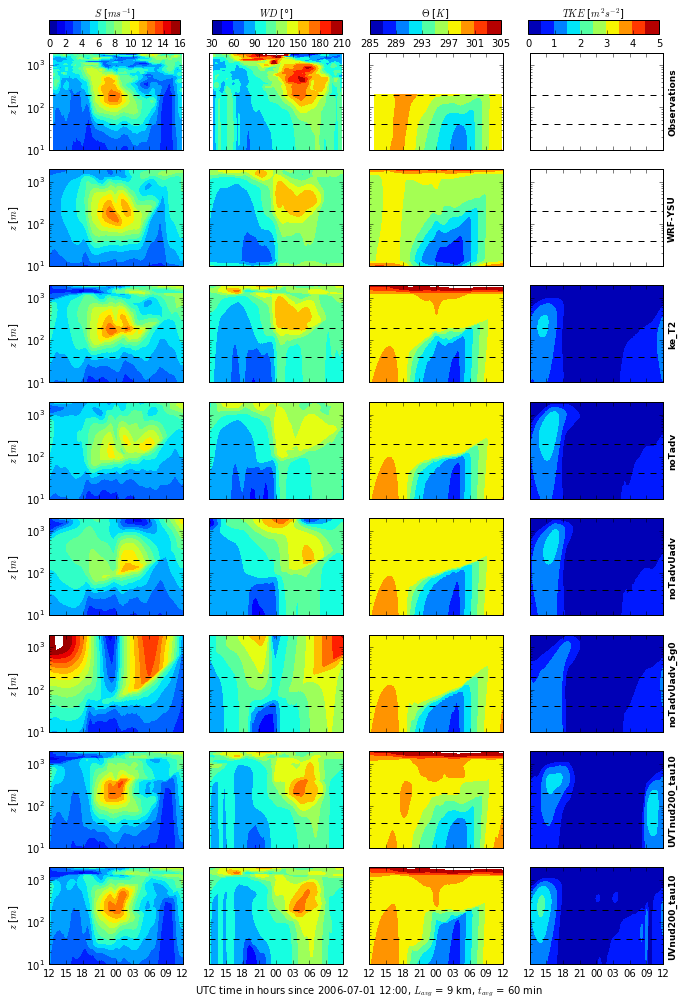

**Fig 1. Time-height contour of horizontal wind speed $S$, direction $WD$, potential temperature $\Theta$ and turbulent kinetic energy $TKE$. Dotted lines denote a rotor diameter of 160 m at 120 m hub-height.**

In [30]:
# Select the simulations you want to plot 
plotsim = np.array([0,1,7,8,9,13,17])

# Plot settings
zlim = 2000                                   # height limit [m]
Zcmap = plt.get_cmap('jet')                   # colormap
figname = siteID+'_tzfields.png'              # output filename
Zlevels = np.array([np.linspace(0,16,17),     # range for S 
                    np.linspace(30,210,13),   # range for WD
                    np.linspace(285,305,11),  # range for Th
                    np.linspace(0,5,11)])     # range for TKE

X = []; Y = []; Z = []; taxis = []; zaxis = []; Ztitle = []
Z = [S_obs_w.T, WD_obs_w.T, Th_obs_w.T, TKE_obs_w.T]
[Xf,Yf] = np.meshgrid(date_obs,zf_obs)
[XT,YT] = np.meshgrid(date_obs,zT_obs)
X = [Xf, Xf, XT, Xf]
Y = [Yf, Yf, YT, Yf]
taxis = [date_obs, date_obs, date_obs, date_obs]
zaxis = [zf_obs, zf_obs, zT_obs, zf_obs]
Ztitle = ['Observations']
for ip in range(0,len(plotsim)):
    isim = plotsim[ip]
    Z.append(S[isim].T)    
    [X0,Y0] = np.meshgrid(t[isim],z[isim])
    taxis.append(t[isim]); zaxis.append(z[isim]); X.append(X0); Y.append(Y0) 
    Z.append(WD[isim].T)    
    [X0,Y0] = np.meshgrid(t[isim],z[isim])
    taxis.append(t[isim]); zaxis.append(z[isim]); X.append(X0); Y.append(Y0) 
    Z.append(Th[isim].T)    
    [X0,Y0] = np.meshgrid(t[isim],z[isim])
    taxis.append(t[isim]); zaxis.append(z[isim]); X.append(X0); Y.append(Y0) 
    Z.append(TKE[isim].T)
    [X0,Y0] = np.meshgrid(t[isim],z[isim])
    taxis.append(t[isim]); zaxis.append(z[isim]); X.append(X0); Y.append(Y0) 
    Ztitle.append(simID[isim])
    
Zlabel = ('$S$ [$m s^{-1}$]','$WD$ ['+u'\N{DEGREE SIGN}'+']','$\Theta$ [$K$]','$TKE$ [$m^{2} s^{-2}$]')
taxis_label = 'UTC time in hours since ' + datefrom.strftime('%Y-%m-%d %H:%M') + ', $L_{avg}$ = ' + "%.0f"%(Lav/1000) + ' km, $t_{avg}$ = ' + "%.0f"%(tav) + ' min'  
zaxis_label = '$z$ [$m$]'
hoursFmt = mdates.DateFormatter('%H')        
Zlevels = np.tile(Zlevels,len(Ztitle))

hoursFmt = mdates.DateFormatter('%H')
tticks = [datefrom + datetime.timedelta(hours = 3*x) for x in range(0, 9)]

fig, ax = plt.subplots(len(Ztitle), 4, sharex='col', sharey='row', figsize=(11,17), dpi=300)
xrotor = np.array([mdates.date2num(datefrom), mdates.date2num(dateto)])
yrotor1 = np.array([Hhub - 0.5*Drot, Hhub - 0.5*Drot])
yrotor2 = np.array([Hhub + 0.5*Drot, Hhub + 0.5*Drot])
cbleft = np.array([0.125,0.33,0.53,0.73])
for iax in range (0,len(Ztitle)*4):
    ix,iy = np.unravel_index(iax,(len(Ztitle),4))
    CF0 = ax[ix,iy].contourf(X[iax],Y[iax],Z[iax], Zlevels[iax], cmap=Zcmap)
    ax[ix,iy].plot(xrotor,yrotor1,'--k')
    ax[ix,iy].plot(xrotor,yrotor2,'--k')
    ax[ix,iy].set_ylim([10, zlim])
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].xaxis.set_major_formatter(hoursFmt)    
    ax[ix,iy].set_xticks(tticks)
    if iy == 0:
        ax[ix,iy].set_ylabel(zaxis_label)
    if iy == 3:
        ax[ix,iy].yaxis.set_label_position("right")
        ax[ix,iy].set_ylabel(Ztitle[ix], fontsize = 9, fontweight='bold')
    if ix == len(Ztitle)-1:
        fig.subplots_adjust(top=0.87)
        cbar_ax = fig.add_axes([cbleft[iy],0.885, 0.165, 0.012])
        cbar = fig.colorbar(CF0, cax=cbar_ax, orientation='horizontal')    
        cbar.ax.set_xlabel(Zlabel[iy],labelpad = -42, x = 0.5)
        
ax[len(Ztitle)-1,1].set_xlabel(taxis_label,x=1.2); 
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
#fig.savefig(figname, bbox_inches='tight', dpi = 300)

plt.show()

from IPython.display import Markdown, display
figcaption = ("**Fig 1. Time-height contour of horizontal wind speed $S$, direction $WD$, "
         "potential temperature $\Theta$ and turbulent kinetic energy $TKE$. Dotted lines " 
         "denote a rotor diameter of 160 m at 120 m hub-height.**")
display(Markdown(figcaption))


## Vertical Profiles

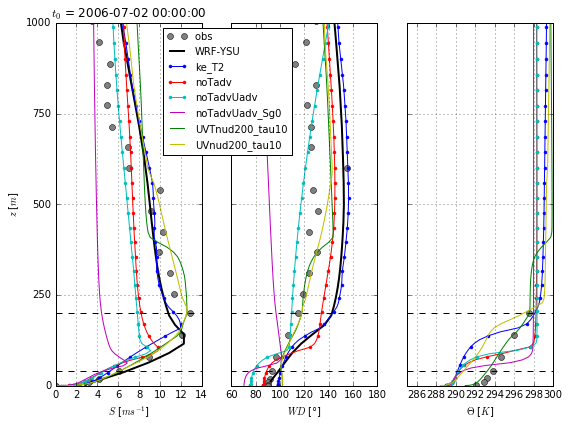

**Fig 2. Vertical profiles of wind speed, wind direction and potential temperature at UTC **2006-07-02 00:00:00

In [31]:
# Specify the datetime at which you want to plot the vertical profiles 
t0 = datetime.datetime(2006,7,2,0,0,0)  

# Plot settings 
linespec = ['k-','b.-','r.-','c.-','m-','g-','y-','c-','b-.','r--']
lwidth = np.array([2,1,1,1,1,1,1,1,2,2])
Nm = 3  # marker every

Z_obs = (S_obs_w.loc[t0].values, WD_obs_w.loc[t0].values,
         Th_obs_w.loc[t0].values)
z_obs = (zf_obs, zf_obs, zT_obs)

Z_sim = []; z_sim = []
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    Z_sim.append((S[isim].loc[t0].values, WD[isim].loc[t0].values,
                  Th[isim].loc[t0].values))
    z_sim.append((z[isim], z[isim], z[isim]))

figname = siteID+'_'+t0.strftime('%Y-%m-%d_%H')+'_profiles.png'

zlim = 1000
fig,ax = plt.subplots(1, 3, sharey='row', figsize=(8,6))
for iax in range (0,3):
    ax[iax].plot(Z_obs[iax], z_obs[iax], 'ok', color='grey', label = 'obs ')
    for iplot in range(0,len(plotsim)):
        isim = plotsim[iplot]
        if (isim == 0 and iax == 2): 
            aa = []
        else:
            ax[iax].plot(Z_sim[iplot][iax][1:], z_sim[iplot][iax][1:], 
                linespec[iplot], linewidth = lwidth[iplot], label = simID[isim], markevery=Nm)
        #ax[iax].set_yscale('log')
    xlim = ax[iax].get_xlim()                    
    ax[iax].plot(xlim,yrotor1,'--k')
    ax[iax].plot(xlim,yrotor2,'--k')
    ax[iax].set_ylim([1., zlim])
    ax[iax].set_yticks(np.linspace(0,zlim,5))
    ax[iax].grid(which='major',color='k',linestyle=':')

#ax[0].set_xlim([0, 16])
ax[1].set_xlim([60, 180])
ax[2].set_xlim([285, 300])
ax[0].set_xlabel('$S$ [$m s^{-1}$]') 
ax[1].set_xlabel('$WD$ ['+u'\N{DEGREE SIGN}'+']')
ax[2].set_xlabel(r'$\Theta$ [$K$]')
ax[0].set_ylabel('$z$ [$m$]')
ax[0].set_title('$t_{0}$ = '+ t0.strftime('%Y-%m-%d %H:%M:%S')) 
ax[1].legend(prop={'size':10},bbox_to_anchor=(-0.5, 1), loc='upper left')
           
plt.setp([a.get_yticklabels() for a in ax[1:]], visible=False)
plt.tight_layout()
#fig.savefig(figname, bbox_inches='tight', format='png', dpi=300)
plt.show()

figcaption = ("**Fig 2. Vertical profiles of wind speed, wind direction "
         "and potential temperature at UTC **"+t0.strftime('%Y-%m-%d %H:%M:%S')) 
display(Markdown(figcaption))

## Surface Fluxes

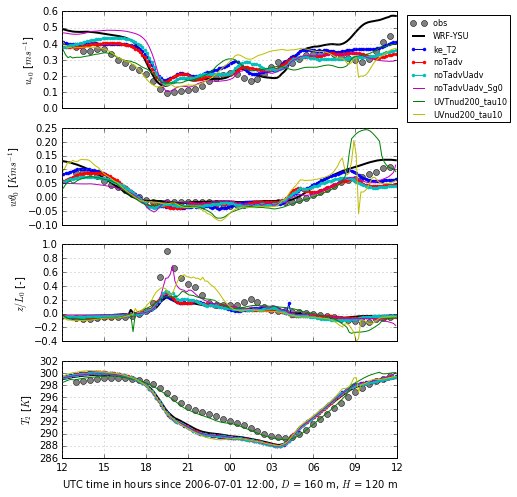

**Fig 3. Surface-layer characteristics**

In [42]:
# Surface fluxes
figname = siteID+'_surfaceflux.png'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(6,8), dpi=300)
ax1.plot(date_obs[::3], ust0_obs_w[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax1.plot(t[isim], us[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim])                        
ax1.set_ylabel(r'$u_{*0}$ [$m s^{-1}$]')
ax1.grid(which='major',color='grey',linestyle=':')
ax1.legend(prop={'size':8}, bbox_to_anchor=(1.35, 1), ncol=1, loc='upper right')

ax2.plot(date_obs[::3], wt0_obs_w[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax2.plot(t[isim], wt[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim])                        
ax2.set_ylabel(r'$w\theta_0$ [$K m s^{-1}$]')
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.1e'))
ax2.grid(which='major',color='grey',linestyle=':')

ax3.plot(date_obs[::3], zflux/L0_obs_w[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax3.plot(t[isim], zflux/L[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim])                        
ax3.set_ylabel(r'$z/L_0$ [-]')
#ax3.set_ylim([-1.5, 1.5])
ax3.grid(which='major',color='grey',linestyle=':')

ax4.plot(date_obs[::3], Th_obs_w[36][::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax4.plot(t[isim], T2[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim])                        
ax4.set_ylabel(r'$T_2$ [$K$]')
ax4.set_xlabel(taxis_label)
ax4.xaxis.set_major_formatter(hoursFmt)
ax4.grid(which='major',color='grey',linestyle=':')
ax4.set_xticks(tticks)
ax4.set_xlim([mdates.date2num(datefrom), mdates.date2num(dateto)])

#fig.savefig(figname, bbox_inches='tight', dpi=300)

plt.show()

figcaption = ("**Fig 3. Surface-layer characteristics**") 
display(Markdown(figcaption))

## Quantities of Interest and Metrics
The performance of the models is based on quantities of interest relevant for wind energy applications.
These quantities are evaluated across a reference rotor span of 160 m, between 40 and 200 m,
characteristic of an 8-MW large wind turbine. Besides hub-height wind speed $S_{hub}$ and direction
$WD_{hub}$, it is relevant to consider the rotor-equivalent wind speed $REWS$, the turbulence intensity (not
evaluated here), the wind speed shear $\alpha$, and the wind direction shear or veer $\psi$.

The REWS is especially suitable to account for wind shear in wind turbine power performance tests
[14]. The REWS is the wind speed corresponding to the kinetic energy flux through the swept rotor
area, when accounting for the vertical shear:

$$ REWS = \left[\frac{1}{A}\sum_{i}(A_iS_i^3\cos\beta_i)\right]^{1/3} $$

where $A$ is the rotor area and $A_i$ are the horizontal segments that separate vertical measurement points
of horizontal wind speed $S_i$ across the rotor plane. The $REWS$ is here weighted by the cosine of the
angle $\beta_i$ of the wind direction $WD_i$ with respect to the hub-height wind direction to account for the
effect of wind veer [15].

Wind shear is defined by fitting a power-law curve across the rotor wind speed points $S_i$:

$$ S_i = S_{hub}\left(\frac{z_i}{z_{hub}}\right)^{\alpha} $$

Similarly, wind veer is defined as the slope $\psi$ of the linear fit of the wind direction difference:

$$ \beta_i = \psi(z_i-z_{hub}) $$

To evaluate simulations and measurements consistently, these quantities are obtained after resampling, by linear interpolation, velocity and wind direction vertical profiles at 10 points across the rotor area and then computing the REWS and the shear functional fits. While these fitting functions are commonly used in wind energy, their suitability in LLJ conditions is questionable. The regression coefficient from the fitting can be used to determine this suitability.

A rolling average with a window size of one hour is applied to simulation and observational data to remove the impact of high frequency fluctuations in the analysis.

Validation results are quantified in terms of the mean absolute error ($MAE$):

$$ MAE = \frac{1}{N}\sum_{i=1}^{N}\left|\chi_{pred}-\chi_{obs}\right| $$

where $\chi$ is any of the above mentioned quantities of interest, predicted (*pred*) or observed (*obs*), and $N$
is the number of samples evaluated in the time series.

In [33]:
# Define rotor-based quantities of interest
zrot = np.linspace(Hhub - 0.5*Drot, Hhub + 0.5*Drot, 1 + Drot/10, endpoint=True)               
def rotor(z,Sz,WDz):
    # Rotor QoIs [m s-1]
    # z: heights [m] where the velocity and wind direction are known spanning the rotor diameter
    # Sz, WDz: Wind speed [m s-1] and direction [deg from N] at z levels [tdim,zdim]
    # Returns:
    #   REWS: rotor equivalent wind speed [m s-1]
    #   alpha: wind shear, power-law exponent from linear fit lg(U/Uhub) = alpha*log(z/zhub)
    #   alpha_R2: R-squared from least squares fit to linear function
    #   veer: wind veer, slope of linear function beta = WDz - WDhub = veer*(z - zhub)
    #   veer_R2: R-squared from least squares fit to linear function
    tdim = Sz.shape[0]
    zdim = Sz.shape[1]    
    Rrot = 0.5*(z[-1]-z[0])    
    Hhub = 0.5*(z[-1]+z[0])
    ihub = int(0.5*len(zrot))
    Arotor = np.pi*(Rrot)**2
    Uz = -Sz*np.sin(np.pi*WDz/180.)
    Vz = -Sz*np.cos(np.pi*WDz/180.)
    Shub = Sz[:,ihub]
    WDhub = WDz[:,ihub]       
    def cz(x,R,H):
        return 2.*(R**2 - (x-H)**2)**0.5
    sumA = np.zeros((Sz.shape[0]))    
    veer = np.zeros((Sz.shape[0]))    
    for i in range(0,zdim-1):
        Ai = integrate.quad(cz, z[i], z[i+1], args = (Rrot,Hhub))    
        Si = 0.5*(Sz[:,i+1]+Sz[:,i])
        Ui = 0.5*(Uz[:,i+1]+Uz[:,i])
        Vi = 0.5*(Vz[:,i+1]+Vz[:,i])   
        WDi = 180. + np.arctan2(Ui,Vi)*180./np.pi       
        betai = WDi - WDhub
        sumA = sumA + Ai[0]*(Si*np.cos(np.pi*betai/180.))**3

    REWS = (sumA/Arotor)**(1./3.)             

    alpha = np.zeros(tdim);    alpha_stderr = np.zeros(tdim); alpha_R2 = np.zeros(tdim)
    veer = np.zeros(tdim);     veer_stderr = np.zeros(tdim); veer_R2 = np.zeros(tdim)
    for it in range(0,tdim):
        regmodel = sm.OLS(np.log(Sz[it,:]/Shub[it]), np.log(z/Hhub))
        results = regmodel.fit()
        alpha[it] = results.params[0]
        alpha_stderr[it] = results.bse[0]
        alpha_R2[it] = results.rsquared
        regmodel = sm.OLS(WDz[it,:] - WDhub[it], z - Hhub)
        results = regmodel.fit()
        veer[it] = results.params[0]
        veer_stderr[it] = results.bse[0]
        veer_R2[it] = results.rsquared

    return REWS, Shub, WDhub, alpha, alpha_R2, veer, veer_R2

Srews_obs = interpolate.interp2d(zf_obs[30:34],date_obs,S_obs_w.values[:,30:34])(zrot,date_obs)
Urews_obs = interpolate.interp2d(zf_obs[30:34],date_obs,U_obs_w.values[:,30:34])(zrot,date_obs)
Vrews_obs = interpolate.interp2d(zf_obs[30:34],date_obs,V_obs_w.values[:,30:34])(zrot,date_obs)
WDrews_obs = 180. + np.arctan2(Urews_obs,Vrews_obs)*180./np.pi       

REWS_obs, Shub_obs, WDhub_obs, alpha_obs, alpha_R2_obs, veer_obs, veer_R2_obs = rotor(zrot,Srews_obs,WDrews_obs)
    
REWS = []; Shub = []; WDhub = []
alpha = []; alpha_R2 = []; veer = []; veer_R2 = []
for isim in range(0,Nsim):
    Srews_sim = interpolate.interp2d(z[isim],np.ravel(t[isim].values),S[isim].values)(zrot,np.ravel(t[isim].values))
    Urews_sim = interpolate.interp2d(z[isim],np.ravel(t[isim].values),U[isim].values)(zrot,np.ravel(t[isim].values))
    Vrews_sim = interpolate.interp2d(z[isim],np.ravel(t[isim].values),V[isim].values)(zrot,np.ravel(t[isim].values))
    WDrews_sim = 180. + np.arctan2(Urews_sim,Vrews_sim)*180./np.pi       
    REWS0, Shub0, WDhub0, alpha0, alpha_R20, veer0, veer_R20 = rotor(zrot,Srews_sim,WDrews_sim)
        
    REWS.append(REWS0)
    Shub.append(Shub0)
    WDhub.append(WDhub0)
    alpha.append(alpha0)    
    alpha_R2.append(alpha_R20)    
    veer.append(veer0)
    veer_R2.append(veer_R20)
    

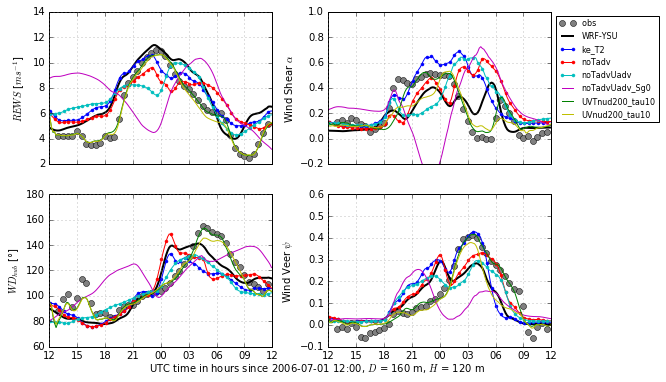

**Fig 4. Time series of rotor rotor-based quantities of interest used for validation**

In [43]:
# plot QoIs
figname = siteID+'_QoIs_rotor.png'

taxis_label = 'UTC time in hours since ' + datefrom.strftime('%Y-%m-%d %H:%M') + ', $D$ = ' + "%.0f"%(Drot) + ' m, $H$ = ' + "%.0f"%(Hhub) + ' m'  
fig, ax = plt.subplots(2, 2, sharex='col', figsize=(9,6), dpi=300)
ax[0][0].plot(date_obs[::3], REWS_obs[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax[0][0].plot(t[isim], REWS[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim], markevery=Nm)                        
ax[0][0].set_ylabel(r'$REWS$ [$m s^{-1}$]')
ax[0][0].grid(which='major',color='grey',linestyle=':')
ax[0][0].set_ylim([2., 14.])

ax[1][0].plot(date_obs[::3], WDhub_obs[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax[1][0].plot(t[isim], WDhub[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim], markevery=Nm)                        
ax[1][0].set_ylabel(r'$WD_{hub}$ ['+u'\N{DEGREE SIGN}'+']')
ax[1][0].grid(which='major',color='grey',linestyle=':')
ax[1][0].set_ylim([60., 180.])
ax[1][0].xaxis.set_major_formatter(hoursFmt)
ax[1][0].set_xticks(tticks)
ax[1][0].set_xlim([mdates.date2num(datefrom), mdates.date2num(dateto)])
ax[1][0].set_xlabel(taxis_label)
ax[1][0].xaxis.set_label_coords(1.2, -0.1)

ax[0][1].plot(date_obs[::3], alpha_obs[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax[0][1].plot(t[isim], alpha[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim], markevery=Nm)                        
ax[0][1].set_ylabel(r'Wind Shear $\alpha$')
ax[0][1].grid(which='major',color='grey',linestyle=':')
ax[0][1].set_ylim([-0.2, 1.0])

ax[1][1].plot(date_obs[::3], veer_obs[::3], 'ok', color='grey', label = 'obs ')
for iplot in range(0,len(plotsim)):
    isim = plotsim[iplot]
    ax[1][1].plot(t[isim], veer[isim], linespec[iplot],linewidth = lwidth[iplot],
                        label = simID[isim], markevery=Nm)                        
ax[1][1].set_ylabel(r'Wind Veer $\psi$')
ax[1][1].grid(which='major',color='grey',linestyle=':')
ax[1][1].set_ylim([-0.1, 0.6])
ax[1][1].xaxis.set_major_formatter(hoursFmt)
ax[1][1].set_xticks(tticks)
ax[1][1].set_xlim([mdates.date2num(datefrom), mdates.date2num(dateto)])

ax[0][1].legend(prop={'size':8}, bbox_to_anchor=(1.5, 1), ncol=1, loc='upper right')
fig.subplots_adjust(wspace=.25)
plt.show()

#fig.savefig(figname, bbox_inches='tight', dpi = 300)

figcaption = ("**Fig 4. Time series of rotor rotor-based quantities of interest used for validation**") 
display(Markdown(figcaption))


In [35]:
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format   # format for output data in tables

# Compute error metics
def mae(xtrue, xpred, norm):
    # Normalized Mean Absolute Error    
    # xtrue: series with true values
    # xpred: series with predicted values
    nonan = ~np.isnan(xtrue)
    if norm == 'True':
        xtrue0 = xtrue[nonan]/np.mean(xtrue[nonan])
        xpred0 = xpred[nonan]/np.mean(xtrue[nonan])
    else:
        xtrue0 = xtrue[nonan]
        xpred0 = xpred[nonan]
            
    N = len(xtrue0)
    abserr = np.abs(xpred0 - xtrue0) 
    MAE = np.sum(abserr)/N
    return MAE

# Errors with respecto to observations
Metrics = pd.DataFrame(np.zeros((Nsim+1, 5)),
                       columns = ['REWS','Shub','WDhub','alpha','veer'],
                       index = ['MAE'] + simID)
Metrics.loc['units',:] = np.array(['m s-1','m s-1','deg','-','-'])
for isim in range(0,Nsim):
    Metrics.loc[(simID[isim]),'REWS'] = mae(REWS_obs,REWS[isim],'False')
    Metrics.loc[(simID[isim]),'Shub'] = mae(Shub_obs,Shub[isim],'False')
    Metrics.loc[(simID[isim]),'WDhub'] = mae(WDhub_obs,WDhub[isim],'False')
    Metrics.loc[(simID[isim]),'alpha'] = mae(alpha_obs,alpha[isim],'False')
    Metrics.loc[(simID[isim]),'veer'] = mae(veer_obs,veer[isim],'False')

tablecaption = ("**Table 1. $MAE_{obs}$ with respect to observations**") 
display(Markdown(tablecaption))
display(Metrics)

**Table 1. $MAE_{obs}$ with respect to observations**

REWS   Shub WDhub alpha veer
MAE               0.00   0.00  0.00  0.00 0.00
WRF-YSU           1.37   1.48 11.59  0.13 0.08
ke_T2             1.42   1.54 12.72  0.14 0.08
Sl_T2             1.87   1.85 11.40  0.19 0.07
kl_T2             1.84   1.81 10.88  0.19 0.07
ke_T2wt           1.40   1.49 12.71  0.13 0.08
ke_Tsk            1.63   1.91 16.39  0.15 0.10
ke_T2obs          1.75   1.77 11.66  0.12 0.09
noTadv            1.44   1.30 13.77  0.17 0.06
noTadvUadv        1.76   1.87 11.78  0.18 0.07
noTadvUadv_Sg0    3.21   3.20 16.17  0.29 0.12
UVTnud80          1.42   1.36 10.33  0.14 0.07
UVTnud120         1.26   1.17 11.85  0.14 0.09
UVTnud200         0.71   0.76  9.36  0.09 0.04
UVTnud200_tau10   0.16   0.19  3.80  0.05 0.02
UVnud400          0.59   0.73 10.13  0.12 0.05
UVnud200          0.66   0.80 10.49  0.12 0.05
UVnud200_tau30    0.45   0.49  7.21  0.10 0.05
UVnud200_tau10    0.26   0.34  4.39  0.08 0.05
units            m s-1  m s-1   deg     -    -

In [39]:
# Errors with respect to reference simulation
refsim = 1    

Metrics2 = pd.DataFrame(np.zeros((Nsim+1, 5)),
                       columns = ['REWS','Shub','WDhub','alpha','veer'],
                       index = ['MAE'] + simID)
Metrics2.loc['units',:] = np.array(['m s-1','m s-1','deg','-','-'])
for isim in range(0,Nsim):
    Metrics2.loc[(simID[isim]),'REWS'] = mae(REWS[refsim],REWS[isim],'False')
    Metrics2.loc[(simID[isim]),'Shub'] = mae(Shub[refsim],Shub[isim],'False')
    Metrics2.loc[(simID[isim]),'WDhub'] = mae(WDhub[refsim],WDhub[isim],'False')
    Metrics2.loc[(simID[isim]),'alpha'] = mae(alpha[refsim],alpha[isim],'False')
    Metrics2.loc[(simID[isim]),'veer'] = mae(veer[refsim],veer[isim],'False')

tablecaption = ("**Table 2: $MAE_{ref}$ with respect to **" +simID[refsim]) 
display(Markdown(tablecaption))
display(Metrics)    


**Table 2: $MAE_{ref}$ with respect to **ke_T2

REWS   Shub WDhub alpha veer
MAE               0.00   0.00  0.00  0.00 0.00
WRF-YSU           1.37   1.48 11.59  0.13 0.08
ke_T2             1.42   1.54 12.72  0.14 0.08
Sl_T2             1.87   1.85 11.40  0.19 0.07
kl_T2             1.84   1.81 10.88  0.19 0.07
ke_T2wt           1.40   1.49 12.71  0.13 0.08
ke_Tsk            1.63   1.91 16.39  0.15 0.10
ke_T2obs          1.75   1.77 11.66  0.12 0.09
noTadv            1.44   1.30 13.77  0.17 0.06
noTadvUadv        1.76   1.87 11.78  0.18 0.07
noTadvUadv_Sg0    3.21   3.20 16.17  0.29 0.12
UVTnud80          1.42   1.36 10.33  0.14 0.07
UVTnud120         1.26   1.17 11.85  0.14 0.09
UVTnud200         0.71   0.76  9.36  0.09 0.04
UVTnud200_tau10   0.16   0.19  3.80  0.05 0.02
UVnud400          0.59   0.73 10.13  0.12 0.05
UVnud200          0.66   0.80 10.49  0.12 0.05
UVnud200_tau30    0.45   0.49  7.21  0.10 0.05
UVnud200_tau10    0.26   0.34  4.39  0.08 0.05
units            m s-1  m s-1   deg     -    -

## Discussion
See discussion about results in [2].

## Conclusions
The GABLS3 diurnal cycle case has been revisited and evaluated in terms of wind energy specific metrics. Instead of using the adjusted mesoscale tendencies of the original GABLS3 set-up, the mesoscale tendencies computed by WRF are directly used to force the SCM. Momentum budget analysis shows the relative importance of the different forcing terms in the momentum equations. By spatial and temporal averaging, the high-frequency fluctuations due to microscale effects are
filtered out. Using mesoscale tendencies to drive the SCM results in consistent flow fields compared to the WRF simulation, even though the more simplified physics of the ABL.

By sensitivity analysis on the mesoscale tendencies, it is shown that the main driver of the ABL is the time and height dependent horizontal pressure gradient. Advection terms come with high uncertainties and hour-to-hour they can lead to
large errors. Nevertheless, their impact in terms of quantities of interest's aggregated errors is positive.

The $k-\epsilon$ model of Sogachev et al. (2012) presents better performance than the lower-order turbulence closure models. Considering surface boundary conditions for the potential temperature equation, prescribing the surface temperature by
indirectly introducing the WRF 2-m temperature with MOST is more adequate than using the skin temperature or the observed 2-m temperature.

Instead of adjusting at mesoscale, corrections are introduced at microscale through observational profile nudging, to make use of the routine measurements collected in wind energy campaigns. Mast-based and lidar-based profiler set-ups are compared to show the added value of measuring at greater heights than the hub-height, main advantage of lidar systems. Sensitivity to the nudging time-scale is large, specially to compensate errors introduced by the mesoscale advection forcing.


## References
[1] Sanz Rodrigo J, Churchfield M, Kosovic B (2016) A wind energy benchmark for ABL modeling of a diurnal cycle with a nocturnal low-level jet: GABLS3 revisited. Journal of Physics: Conference Series 753, 032024, doi:10.1088/1742-6596/753/3/032024

[2] Sanz Rodrigo J, Churchfield M, Kosovic B (2017) A methodology for the design and testing of atmospheric boundary layer models for wind energy applications. Wind Energ. Sci. 2: 1-20, doi:10.5194/wes-2-1-2017

[3] Sogachev A, Kelly M, Leclerc MY (2012) Consistent Two-Equation Closure Modelling for Atmospheric Research: Buoyancy and Vegetation Implementations. Boundary-Layer Meteorol. 145(2): 307–327, doi:10.1007/s10546-012-9726-5,2012.


## Acknowledgements
This work was produced with funding from the ‘MesoWake’ Marie Curie International Outgoing Fellowship (FP7-PEOPLE-2013-IOF, European Commission’s grant agreement number 624562).
